In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pymatch.Matcher import Matcher

## Load data

In [2]:
p_pheno = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/pheno_26-01-22.csv'

pheno = pd.read_csv(p_pheno,index_col=0)

/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
case = 'DUP22q11_2'
control = 'CON_IPC' if case in ['SZ','ASD','BIP'] else 'non_carriers'

conf = ['AGE',
        'SEX',
        #'SITE',
        'mean_conn',
        'FD_scrubbed']

df_con = pheno[(pheno[control] == 1)&(pheno['PI'].isin(pheno[pheno[case] == 1]['PI'].unique()))][conf + [case]]
df_case = pheno[pheno[case]==1][conf + [case]]

df_con.loc[:,case] = df_con.loc[:,case].astype(int)
df_case.loc[:,case] = df_case.loc[:,case].astype(int)

In [4]:
m = Matcher(df_case,df_con,yvar=case)

Formula:
Q('DUP22q11_2') ~ Q('AGE')+Q('FD_scrubbed')+Q('SEX')+Q('mean_conn')
n majority: 30275
n minority: 22


In [5]:
np.random.seed(1)

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 78.91%


/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


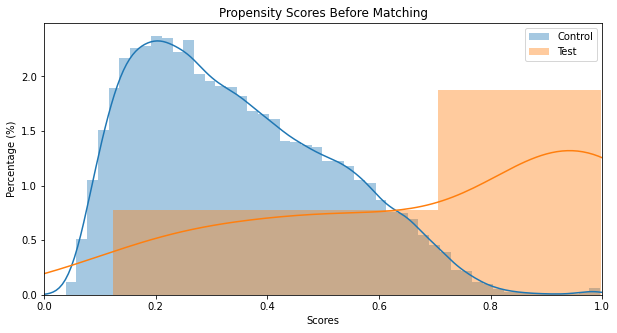

In [6]:
m.predict_scores()
m.plot_scores()

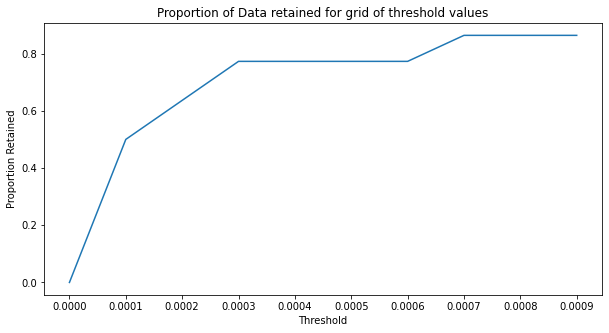

In [7]:
m.tune_threshold(method='min')

In [8]:
m.match(method="min", nmatches=1, threshold=0.0009,with_replacement=False)

In [9]:
m.record_frequency()

,freq,n_records
0,1,36


In [10]:
m.assign_weight_vector()

In [11]:
m.matched_data.sort_values("match_id").head(6)

,record_id,weight,AGE,DUP22q11_2,FD_scrubbed,SEX,mean_conn,og_idx,scores,match_id
0,0,1.0,65.072581,1,0.145739,Female,0.622656,sub1010156,0.296319,1
28,25829,1.0,65.844086,0,0.171700,Female,0.504528,sub4761183,0.296875,1
14,16,1.0,13.000000,1,0.163262,Female,0.351835,Qx0285x03182015,0.986936,2
31,30263,1.0,16.000000,0,0.184923,Female,0.423568,Qx0077x03112013,0.986319,2
33,30270,1.0,11.000000,0,0.113646,Male,0.215936,Qx0101x01032013,0.973272,3
11,12,1.0,15.000000,1,0.085005,Female,0.410396,Qx0177x05012012,0.973551,3


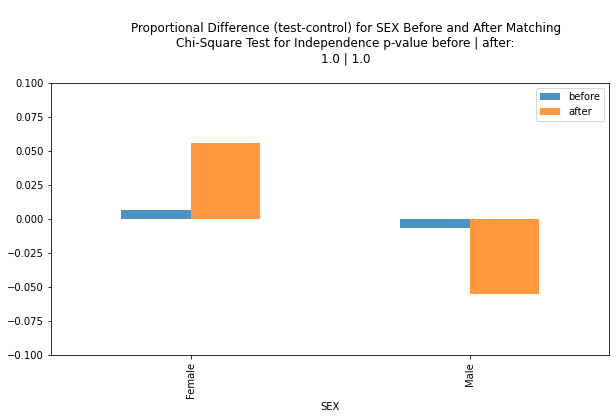

In [12]:
categorical_results = m.compare_categorical(return_table=True)

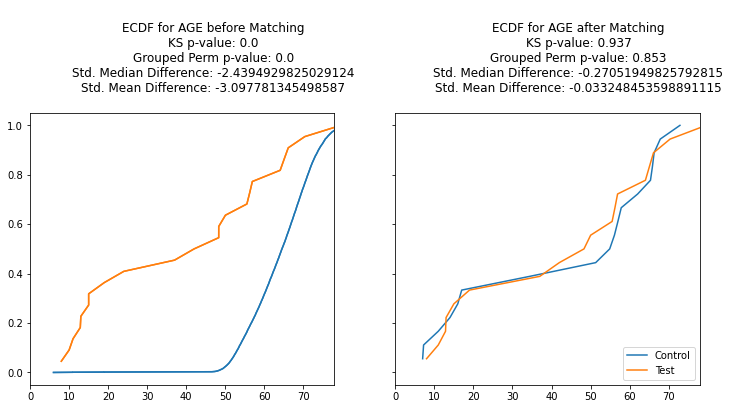

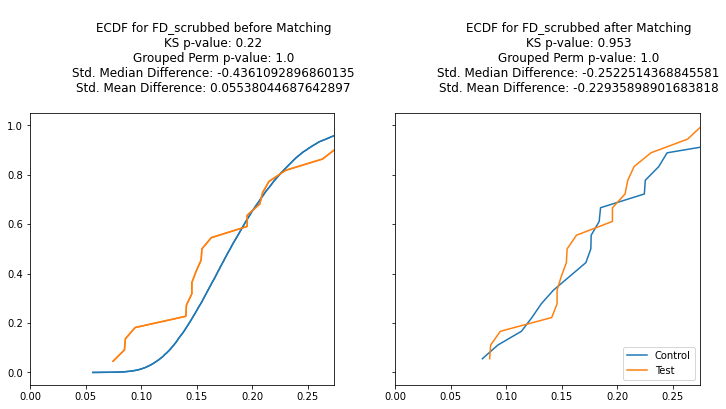

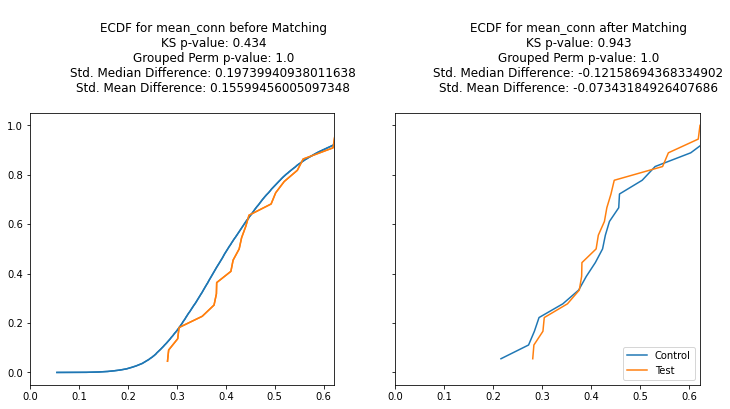

In [13]:
cc = m.compare_continuous(return_table=True)

In [14]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,AGE,0.000,0.937,0.0,0.853,-2.439493,-0.270519,-3.097781,-0.033248
1,FD_scrubbed,0.220,0.953,1.0,1.000,-0.436109,-0.252251,0.055380,-0.229359
2,mean_conn,0.434,0.943,1.0,1.000,0.197399,-0.121587,0.155995,-0.073432


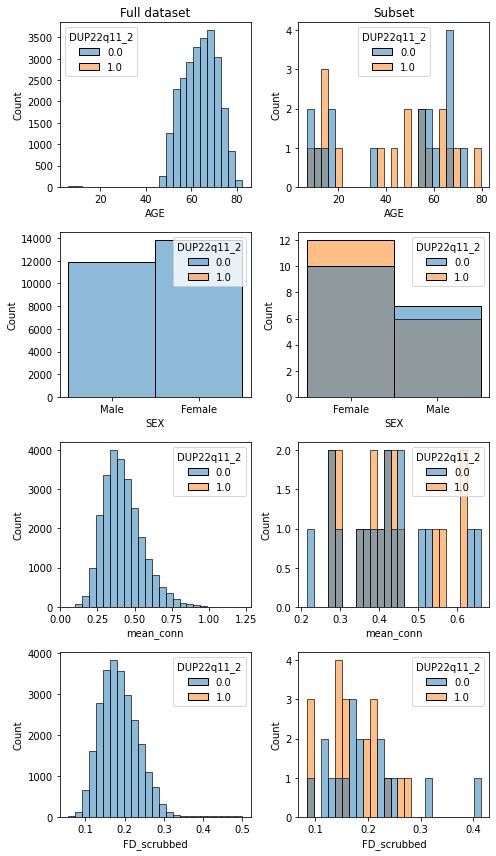

In [15]:
ids = m.matched_data['og_idx'].to_list()
        

sites = pheno[pheno[case]==1]['SITE'].unique()
df = pheno[(pheno['SITE'].isin(sites))
        & ((pheno[case]==1)|(pheno[control]==1))]

fig, ax = plt.subplots(len(conf),2,figsize=(7,12))
for i,c in enumerate(conf):
        sns.histplot(x=c,data=df,hue=case,bins=25,ax=ax[i,0])
        
        sns.histplot(x=c,data=df[df.index.isin(ids)],hue=case,bins=25,ax=ax[i,1])
        if i == 0:
                ax[i,0].set_title('Full dataset')
                ax[i,1].set_title('Subset')
plt.tight_layout()

In [16]:
print('Unique matched cases: ',m.matched_data[m.matched_data[case]==1]['og_idx'].nunique())
print('Unique matched controls: ',m.matched_data[m.matched_data[case]==0]['og_idx'].nunique())

Unique matched cases:  18
Unique matched controls:  18
